# Interpolation of model gridded data along satellite tracks

* The space-time interpolation is made with the software Gonzag (https://github.com/brodeau/gonzag) from Laurent Brodeau, based on the Akima interpolation method. To download the software: `git clone https://github.com/brodeau/gonzag.git`

*  Each file is 6-month long. The model gridded files and the satellite along track data have been prepared and downloaded previously (see this notebook).

* The present notebook reads the files and perform the interpolation, and then save outputs.

* In  each file you’ll find:
    - sla_unfiltered (the real obs value (SLA)
    - sossheig (Sea Surface Height interpolated at all alongtrack locations)
    - sossheig_np (Sea Surface Height at nearest model grid point )

# Imports

In [1]:
import sys
from os import getenv
import warnings
import pkg_resources
import numpy as nmp
import datetime
# xarray
import xarray as xr


# import gonzag (to download the software: git clone https://github.com/brodeau/gonzag.git)
warnings.filterwarnings("ignore")
GONZAG_DIR   = '/gpfswork/rech/egi/regi915/DEVGIT/gonzag'
sys.path.append(GONZAG_DIR)
import gonzag as gzg
from gonzag.ncio import SaveTimeSeries, Save2Dfield
from gonzag.config import IsZarr,ldebug, rmissval, l_save_track_on_model_grid

# custom tools for plotting purposes
import libslx as slx


# cartopy
import cartopy
import cartopy.crs as ccrs

# matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

In [2]:
# list packages version for the record
root_packages = ['cartopy','argparse','numpy', 'netCDF4', 'time','datetime','calendar','shapely','matplotlib']

# print versions, but check if package is imported first
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print(f"{m.project_name}=={m.version}") 

Shapely==1.7.1
numpy==1.20.0
matplotlib==3.3.4
Cartopy==0.18.0


# Initializations

In [10]:
# ------------------------------------ INTPUT (SATELLITE)
# satellite directory
GONZAG_DATA_DIR = '/gpfsstore/rech/egi/regi915/EUROSEA/SAT/NRT'

# Satellite input data:
name_sat = 'jason3'

# 6-month segment to consider in sat data and model data
# year
YR=2020

seg=1 # Seg1: july to dec. 
#seg=2 # Seg2: jan to june

if seg==1:
    da=str(YR)+'07-'+str(YR+1)+'01'
    damod=str(YR)+"m07-12"
if seg==2:
    da=str(YR)+'01-'+str(YR)+'07'
    damod=str(YR)+"m01-06"

# file name
file_sat = GONZAG_DATA_DIR+'/JASON3_'+da+'.nc'
# variable to read
name_ssh_sat = 'sla_unfiltered'
name_mdt_sat = 'mdt'


# ------------------------------------ INTPUT (MODEL)
# model gridded data directory
GONZAG_MOD_DIR = '/gpfsstore/rech/egi/regi915/EUROSEA/MOD'

# Model input data:
name_mod = 'eNATL60-WestMed'
file_mod = GONZAG_MOD_DIR+"/eNATL60MEDWEST-BLB002_y"+damod+".1h_sossheig_corrnc.nc4.02"
                                   
# variable to read: SSH
name_ssh_mod = 'sossheig'
file_lsm_mod = file_mod; 
name_lsm_mod = '_FillValue' ; # we use _FillValue attribute of "nams_ssh_mod" in "file_mod"
l_griddist = False ; # grid is not strongly distorded (set to True in the Arctic region for instance)


# ------------------------------------ OUTPUT
# output directory for the interpolation result
diro = '/gpfsstore/rech/egi/regi915/EUROSEA/NRT_INTERP/'

#name of output file
namo='interpres_'+name_sat+'_'+da

# Start interpolation steps

### 1. Time overlap between model and satellite data ?

In [11]:
(it1,it2), (Nts,Ntm) = gzg.GetEpochTimeOverlap( file_sat , file_mod )
print(' *** Time overlap between model and satellite in UNIX epoch time: it1, it2', it1,'--',it2)
print('   => UTC: "'+gzg.EpochT2Str(it1)+'" to "'+gzg.EpochT2Str(it2)+'"\n')

 *** Time overlap between model and satellite in UNIX epoch time: it1, it2 1593563400.0 -- 1609457400.0
   => UTC: "Wed Jul  1 00:30:00 2020" to "Thu Dec 31 23:30:00 2020"



### 2. Create object `ModelGrid` containing all the model (aka _source_) 2D+T domain grid info

In [12]:
clsm = name_lsm_mod
if name_lsm_mod=='_FillValue': clsm = name_lsm_mod+'@'+name_ssh_mod

ModelGrid = gzg.ModGrid( file_mod, it1, it2, file_lsm_mod, clsm, distorded_grid=l_griddist )


 *** what we use to define model land-sea mask:
    => "_FillValue@sossheig" in "/gpfsstore/rech/egi/regi915/EUROSEA/MOD/eNATL60MEDWEST-BLB002_y2020m07-12.1h_sossheig_corrnc.nc4.02"

 *** Skipping computation of angle distortion of the model grid! ("-D" option not invoked)...

 *** About model gridded (source) domain:
     * shape =  (803, 883)
     * horizontal resolution:  0.01675373254921055  degrees or  1.861507223542784  km
     * Is this a global domain w.r.t longitude:  False
       ==> this is a regional domain
       ==> working in the [-180:180] frame...
     * lon_min, lon_max =  -5.68 9.6
     * lat_min, lat_max =  34.85 45.14
     * should we pay attention to possible STRONG local distorsion in the grid:  False
     * number of time records of interest for the interpolation to come:  4416
       ==> time record indices: 0 to 4415, included



### 3. Create object `SatelliteTrack` containing all the satellite track (aka _target_) info

In [13]:
SatelliteTrack = gzg.SatTrack( file_sat, it1, it2, Np=Nts, \
                              domain_bounds=ModelGrid.domain_bounds, l_0_360=ModelGrid.l360 )

 *** [SatTrack()] Analyzing the time vector in /gpfsstore/rech/egi/regi915/EUROSEA/SAT/NRT/JASON3_202007-202101.nc ...

 *** About satellite track (target) domain:
     * number of time records of interest for the interpolation to come:  18116
       ==> time record indices: 52418 to 9191312, included



### 4. Build the bilinear mapping & Perform the space-time interpolation

In [14]:
Solution = gzg.Model2SatTrack(ModelGrid, name_ssh_mod, SatelliteTrack, name_ssh_sat)

 *** "found" distance criterion when searching for nearest point on model grid is  1.3961304176570881  km

 *** Will use zoom boxes of width of 269 points for 1st attempts of nearest-point location...


 *** Finding nearest points on source (model) grid... (rd_found_km, np_box_r = 1.3961304176570881 134 )
      +++ Treated point: 1811/18116 
          ==> Sat. coordinates:     38.436 0.887
          ==> Model nearest point:  38.438 0.884  ( 268 388 )
      +++ Treated point: 3622/18116 
          ==> Sat. coordinates:     38.341 7.687
          ==> Model nearest point:  38.341 7.692  ( 273 795 )
      +++ Treated point: 5433/18116 
          ==> Sat. coordinates:     36.541 -2.472
          ==> Model nearest point:  36.547 357.535  ( 117 191 )
      +++ Treated point: 7244/18116 
          ==> Sat. coordinates:     41.039 2.936
          ==> Model nearest point:  41.04 2.931  ( 483 503 )
      +++ Treated point: 9055/18116 
          ==> Sat. coordinates:     37.613 3.169
          ==>

### --> Now the object `Solution` contains everything you need to start the plots and the science... 

### 4. Quick plot on map as a check

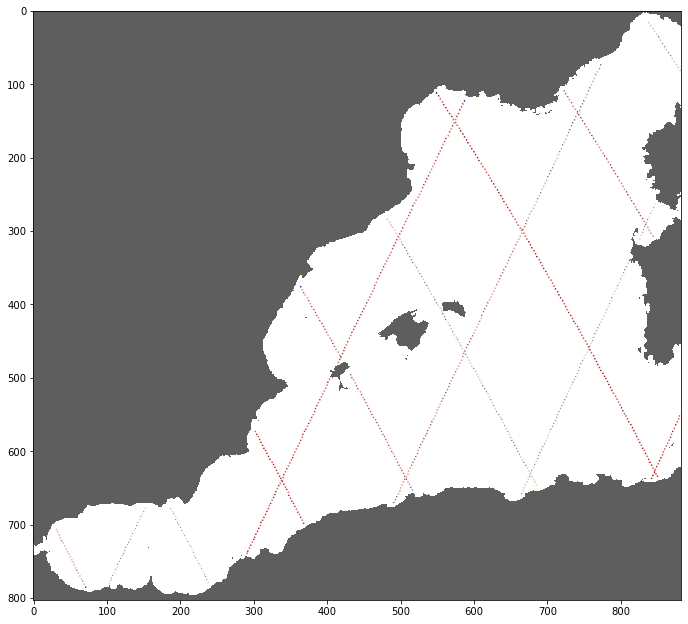

In [15]:
# MAP PLOT

XFLD = nmp.flipud(Solution.XNPtrack)
(idy,idx) = nmp.where( XFLD > 0 ) ; # that's track points...

XMSK = 1 - nmp.ma.getmask(XFLD).astype(nmp.int8)
pmsk = nmp.ma.masked_where(XMSK<0.1, XMSK*0.7)
del XMSK

(Nj,Ni) = XFLD.shape

fig = plt.figure(num = 1, figsize=(9,9*Nj/Ni), facecolor='w', edgecolor='k')
ax  = plt.axes([0., 0., 1., 1.],     facecolor = 'w')
norm_fld = colors.Normalize(vmin =nmp.amin(XFLD[(idy,idx)]), vmax=nmp.amax(XFLD[(idy,idx)]), clip = False)

# plot obs locations 
cf = ax.scatter(idx, idy, c=XFLD[(idy,idx)], cmap = 'nipy_spectral', norm = norm_fld, alpha=0.5, marker='.', s=3 )
#
norm_lsm = colors.Normalize(vmin = 0., vmax = 1., clip = False)

# plot model mask
cm = ax.imshow(pmsk, cmap='Greys', norm=norm_lsm, interpolation='none')


### 5. Write output in netcdf file

In [16]:
c1     = 'Model SSH interpolated in space (' ; c2=') and time on satellite track'
vvar   = [ 'latitude', 'longitude', name_ssh_mod+'_np'   , name_ssh_mod+'_bl' , name_ssh_sat          , 'distance'                        ]
vunits = [ 'deg.N'   , 'deg.E'    ,          'm'         ,     'm'            ,    'm'                ,    'km'                               ]
vlongN = [ 'Latitude', 'Longitude', c1+'nearest-point'+c2,  c1+'bilinear'+c2  , 'Input satellite data', 'Cumulated distance from first point' ]

iw = SaveTimeSeries( Solution.time, \
                     nmp.array( [Solution.lat, Solution.lon, Solution.ssh_mod_np, Solution.ssh_mod, Solution.ssh_sat, Solution.distance] ), \
                     vvar, diro+namo+'.nc', \
                     time_units='seconds since 1970-01-01 00:00:00', \
                     vunits=vunits, vlnm=vlongN, missing_val=rmissval )


 *** About to write file "/gpfsstore/rech/egi/regi915/EUROSEA/NRT_INTERP/interpres_jason3_202007-202101.nc"...
   ==> writing "time"
   ==> writing "latitude"
   ==> writing "longitude"
   ==> writing "sossheig_np"
   ==> writing "sossheig_bl"
   ==> writing "sla_unfiltered"
   ==> writing "distance"
 *** "/gpfsstore/rech/egi/regi915/EUROSEA/NRT_INTERP/interpres_jason3_202007-202101.nc" successfully written!



## You're done with the interpolation. --> Now look to notebook 'check_and_plot' to see how to read the interoplated file and plot tracks as a check.